In [14]:
import os
import os.path as osp
import json

data_root = '/data_new/chence/LPFF'
print('data_root', data_root)

align_images_dir = os.path.join(data_root, 'align_images')
align_parsing_dir = os.path.join(data_root, 'align_parsing')
head_images_dir = os.path.join(data_root, 'head_images')
head_parsing_dir = os.path.join(data_root, 'head_parsing')
meta_json_file = os.path.join(data_root, 'meta_hq.json')
assert os.path.exists(align_images_dir)
assert os.path.exists(align_parsing_dir)
assert os.path.exists(head_images_dir)
assert os.path.exists(head_parsing_dir)
assert os.path.exists(meta_json_file)

with open(meta_json_file, 'r') as f:
    cur_meta_data = json.load(f)

data_root /data_new/chence/LPFF


In [15]:
import imagesize
import tqdm

def check_iv2b_ratio(data_input):
    data_root, cur_key, cur_box_key, cur_file, cur_box = data_input
    bx_min, by_min, bw, bh = cur_box
    bx_max, by_max = bx_min + bw, by_min + bh
    img_w, img_h = imagesize.get(osp.join(data_root, cur_file))
    vx_min, vy_min = max(0, bx_min), max(0, by_min)
    vx_max, vy_max = min(img_w, bx_max), min(img_h, by_max)
    vw, vh = vx_max - vx_min, vy_max - vy_min
    v2b_ratio = (vw * vh) / (bw * bh)
    iv2b_ratio = 1.0 - v2b_ratio
    info_dict = {
        'box': cur_box,
        'image_wh': [img_w, img_h],
        'vbox': [vx_min, vy_min, vw, vh],
        'v2b_ratio': v2b_ratio,
        'iv2b_ratio': iv2b_ratio,
    }
    return (cur_key, cur_box_key, info_dict)


data_inputs = []
for cur_key in tqdm.tqdm(cur_meta_data.keys()):
    cur_file = cur_meta_data[cur_key]['raw']['file_path']
    for cur_box_key in cur_meta_data[cur_key]['raw']['head_boxes'].keys():
        cur_box = cur_meta_data[cur_key]['raw']['head_boxes'][cur_box_key]
        data_inputs.append((data_root, cur_key, cur_box_key, cur_file, cur_box))

100%|██████████| 14293/14293 [00:00<00:00, 196516.05it/s]


In [16]:
from multiprocessing import Pool

with Pool(processes=24) as pool:
    mp_results = list(tqdm.tqdm(pool.imap(check_iv2b_ratio, data_inputs), total=len(data_inputs)))

100%|██████████| 26141/26141 [01:36<00:00, 270.12it/s]


In [17]:
head_box_info = {}
for i in tqdm.trange(len(mp_results)):
    cur_key, cur_box_key, info_dict = mp_results[i]
    if cur_key not in head_box_info.keys():
        head_box_info[cur_key] = {}
    head_box_info[cur_key][cur_box_key] = info_dict

iv2b_ratios = []
for cur_key in tqdm.tqdm(cur_meta_data.keys()):
    for cur_box_key in cur_meta_data[cur_key]['raw']['head_boxes'].keys():
        iv2b_ratios.append(head_box_info[cur_key][cur_box_key]['iv2b_ratio'])

100%|██████████| 14293/14293 [00:00<00:00, 170098.53it/s]


In [18]:
with open('temp/lpff_iv2b_ratios.json', 'w') as f:
    json.dump(head_box_info, f, indent=4)

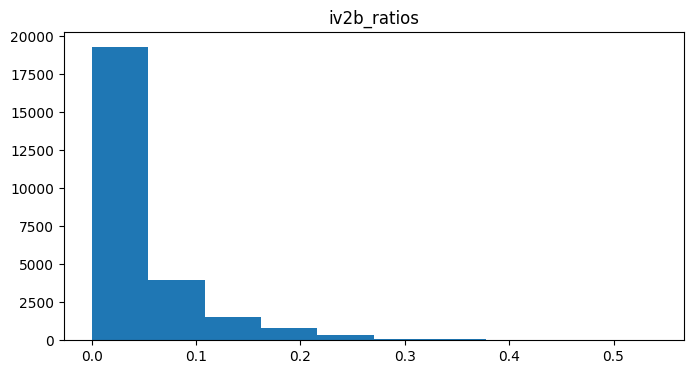

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))
# plt.xscale('log')
plt.hist(iv2b_ratios, bins=10)
plt.title('iv2b_ratios')
plt.show()

In [29]:
selected_keys = {}

for cur_key in tqdm.tqdm(cur_meta_data.keys()):
    for cur_box_key in cur_meta_data[cur_key]['raw']['head_boxes'].keys():
        cur_iv2b_ratio = head_box_info[cur_key][cur_box_key]['iv2b_ratio']
        if cur_iv2b_ratio > 0.3:
            selected_keys[f"{cur_key}|{cur_box_key}"] = cur_iv2b_ratio
selected_keys = dict(sorted(selected_keys.items(), key=lambda x: x[1], reverse=True))
print('selected_keys', len(selected_keys))

100%|██████████| 14293/14293 [00:00<00:00, 217648.81it/s]

selected_keys 157


In [27]:
import cv2

save_dir = 'temp/LPFF'

s_keys = list(selected_keys.keys())
os.makedirs(save_dir, exist_ok=True)

for idx in tqdm.trange(len(s_keys)):
    s_key = list(selected_keys.keys())[idx]
    # print(s_key, selected_keys[s_key])
    cur_key, cur_box_key = s_key.split('|')
    box = cur_meta_data[cur_key]['raw']['head_boxes'][cur_box_key]
    cur_file = cur_meta_data[cur_key]['raw']['file_path']
    cur_image_data = cv2.imread(osp.join(data_root, cur_file))

    from visualize.vis_2d import draw_detection_box

    a = draw_detection_box(cur_image_data, box, text='')
    save_name = f"{selected_keys[s_key]:.2f}_"+s_key.replace('|', '_').replace('/', '_')+".jpg"
    save_path = osp.join(save_dir, save_name)
    if not osp.exists(save_path):
        cv2.imwrite(save_path, a)
    # print(save_name)

    # from PIL import Image

    # # display(Image.fromarray(cur_image_data[..., ::-1]))
    # display(Image.fromarray(a[..., ::-1]))

100%|██████████| 157/157 [01:26<00:00,  1.81it/s]
